/home/lincy/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


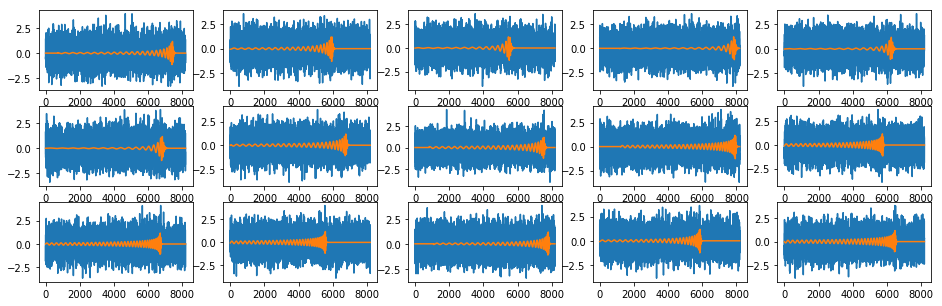

In [1]:
###
###  Prepare data: extract, transform, load (ETL)
###
import h5py as h5
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
    
import os
import time
from datetime import datetime

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

LABLE_WIDTH = 1
X_FEATURE = 'x'  # Name of the input feature.

RATE = 8192

#FLAGS = tf.app.flags.FLAGS
#tf.app.flags.DEFINE_string("train_data_path", "/home/yongcai/chinese_fenci/train.txt", "training data dir")
#tf.app.flags.DEFINE_string("log_dir", "./logs", " the log dir")
#tf.app.flags.DEFINE_integer("max_sentence_len", 80, "max num of tokens per query")
#tf.app.flags.DEFINE_integer("shuffle_buffer_size", )

class GWInject():
    def _shift_noise(self, tag, A, shift):
        MAX=self.srate
        var = self.f[tag]

        NX = len(var)
        X  = np.random.normal(0,1,(NX,self.srate))
        NN = NX
        ## make shifted template first
        swf = np.zeros(var.shape)
        for i in range(NX):
            a = int((np.random.random()-0.5)*shift)  ## shift left or right
            swf[i,max(0,a):min(MAX, MAX+a)] += A * np.roll(var[i], a)[max(0,a):min(MAX, MAX+a)]
            
        X = np.vstack( (X, (A * swf[:NX,:] + X) )       ).astype(np.float32)
        Y = np.array([0]*NX + [1]*NX).astype(np.float32).reshape(-1,1)
        
        if self.plot:
            plt.figure(figsize=(16,5))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)
                plt.plot(X[NX+i,:])
                plt.plot(swf[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.show()

        return X, Y
    def _add_noise(self, tag, A):
        var = self.f[tag]
        NX = len(var)
        X = np.random.normal(0,1,(NX,self.srate))
        X = np.vstack( (X,  (A * var[:NX,:] + X )   )  ).astype(np.float32)
        Y = np.array([0]*NX + [1]*NX).astype(np.float32).reshape(-1,1)
        
        if self.plot:
            plt.figure(figsize=(16,5))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)
                plt.plot(X[i,:])
                plt.plot(A * var[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.show()

        return X, Y
    def __init__(self, fname, plot=0):
        self.fname = fname
        self.plot = plot
        self.f = h5.File(fname, "r")
        self.srate = self.f.attrs.get('srate')

    def __exit__(self):
        self.f.close()
        
    def get_train_val_set(self, A=1.0):
        X, Y = self._add_noise('/train', A)
        return X, Y
    def get_test_set(self, A=1.0):
        return self._add_noise('/test', A)

    def get_shifted_train_val_set(self, A=1.0, shift=0):
        X, Y = self._shift_noise('/train', A, shift)
        #X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=None)
        return X, Y

    def get_shifted_test_set(self, A=1.0, shift=0):
        return self._shift_noise('/test', A, shift)
    
    
tmp = GWInject("white_h_fixed.h5", plot=1)
Xt, Xv = tmp.get_shifted_test_set(A=1.0, shift=2500)    
tmp.__exit__()


In [2]:
###
### Prepare NN model: small model
###
def model(x_, keep_prob, WIDTH):
    feature = tf.reshape(x_, [-1, WIDTH,1])

    args = {"padding":'valid', "activation":None,
            "kernel_initializer":tf.truncated_normal_initializer(), 
            "bias_initializer":tf.zeros_initializer()     }
    
    def convl(in_, F, K, D, S, PO, PS, act):
        out = tf.layers.conv1d( in_, filters=F, kernel_size=K, dilation_rate=D, strides=S, **args)
        out = tf.layers.max_pooling1d(out, pool_size=PO, strides=PS, padding='valid')
        return act(out)
        
    o1 = convl(feature, F=16, K=16, D=1, S=1, PO=4, PS=4, act=tf.nn.relu)
    o2 = convl(o1,      F=32, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    o3 = convl(o2,      F=64, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    
    dim = o3.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    o4 = tf.reshape(o3, [-1, fcnn])
    # Densely connected layer
    o4     = tf.layers.dense(o4, 64, activation=tf.nn.relu, name="fc")
    logits = tf.layers.dense(o4, 1, activation=None)
    
    return logits


In [3]:
###
### Prepare NN model: larger model
###
def model_hi(x_, keep_prob, WIDTH):
    """
    Model that return logits
    """
    args = {"padding":'valid', "activation":None, 
        "kernel_initializer":tf.truncated_normal_initializer(), 
        "bias_initializer":tf.zeros_initializer()     }
    def convl(in_, F, K, D, S, PO, PS, act):
        out = tf.layers.conv1d( in_, filters=F, kernel_size=K, dilation_rate=D, strides=S, **args)
        out = tf.layers.max_pooling1d(out, pool_size=PO, strides=PS, padding='valid')
        return act(out)
    
    feature = tf.reshape(x_, [-1, WIDTH,1])
    c1 = convl(feature, F= 64, K=16, D=1, S=1, PO=4, PS=4, act=tf.nn.relu)
    c2 = convl(c1,      F=128, K=16, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)
    c3 = convl(c2,      F=256, K=16, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)
    c4 = convl(c3,      F=512, K=32, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)

    dim = c4.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    l1 = tf.reshape(c4, [-1, fcnn])
    
    l2     = tf.layers.dense(l1, 128, activation=tf.nn.relu)
    l3     = tf.layers.dense(l2,  64, activation=tf.nn.relu)
    logits = tf.layers.dense(l3,   1, activation=None)
   
    return logits


In [4]:
###
###  Construct TF graph
###
tf.reset_default_graph()
DIM   = 8192
LRATE = 1e-4
keep_prob = tf.placeholder(tf.float32)   ##  for dropout, not used.
#bs        = tf.placeholder(tf.int64)     ##  use dynamics batch_size to account for train/test stage both

x = tf.placeholder(tf.float32, [None,DIM])
y = tf.placeholder(tf.float32, [None,1])

logits = model(x, keep_prob, DIM)
#logits = model_hi(features, keep_prob, DIM)

# Compute predictions
with tf.name_scope('eval'):
    predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
    predict_op   = tf.cast( tf.round(predict_prob), tf.int32 )
with tf.name_scope('loss'):
    ## with reduction compared to tf.nn.softmax_cross_entropy_with_logits_v2 
    loss_op = tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=y)
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(LRATE).minimize(loss_op)
    #optimizer = tf.train.AdadeltaOptimizer(LRATE, rho=0.90, epsilon=1e-08).minimize(loss_op)
    #optimizer = tf.train.GradientDescentOptimizer(LRATE).minimize(loss_op)

#correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
#correct_prediction = tf.cast(correct_prediction, tf.float32)
#accuracy = tf.reduce_mean(correct_prediction)
_, accuracy    = tf.metrics.accuracy(labels=y, predictions=predict_op  )
_, sensitivity = tf.metrics.recall(labels=y, predictions=predict_op  )

_, fp = tf.metrics.false_positives(labels=y, predictions=predict_op  )
_, fn = tf.metrics.false_negatives(labels=y, predictions=predict_op  )
_, tp = tf.metrics.true_positives(labels=y, predictions=predict_op  )
_, tn = tf.metrics.true_negatives(labels=y, predictions=predict_op  )

tf.summary.histogram('loss', loss_op)
tf.summary.scalar('loss', loss_op)
tf.summary.scalar('accuracy', accuracy)



Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [5]:
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope("summaries_%s"% var.name.replace("/", "_").replace(":", "_")):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

### check all variables
if 1:
    vars = 0
    for v in tf.global_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Whole size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.global_variables()) ) )

    vars = 0
    for v in tf.trainable_variables():
        print (v)
        variable_summaries(v)
        vars += np.prod(v.get_shape().as_list())
    print("Model size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.trainable_variables()) ) )

    vars = 0
    for v in tf.local_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Local var size: %.3f Bytes | Var # : %d" % (8*vars, len(tf.local_variables()) ) )

<tf.Variable 'conv1d/kernel:0' shape=(16, 1, 16) dtype=float32_ref>
<tf.Variable 'conv1d/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv1d_1/kernel:0' shape=(8, 16, 32) dtype=float32_ref>
<tf.Variable 'conv1d_1/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'conv1d_2/kernel:0' shape=(8, 32, 64) dtype=float32_ref>
<tf.Variable 'conv1d_2/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'fc/kernel:0' shape=(7616, 64) dtype=float32_ref>
<tf.Variable 'fc/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(64, 1) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'optimizer/beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'optimizer/beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'conv1d/kernel/Adam:0' shape=(16, 1, 16) dtype=float32_ref>
<tf.Variable 'conv1d/kernel/Adam_1:0' shape=(16, 1, 16) dtype=float32_ref>
<tf.Variable 'conv1d/bias/Adam:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv1d/

In [6]:
##
##  Training with fixed template ....
##
if 0:
    for i in range(10):
        feature, label = iter.get_next()
        print (feature.shape, label.shape)
       
    
GWdata = GWInject("white_h_fixed.h5")
#Xt, Xv, Yt, Yv = GWdata.get_train_val_set()
#nXt = Xt.shape[0]
#nXv = Xv.shape[0]

BATCH = 128
EPOCHS = 100
MONITOR = 2

PATIENCE = 4
TOLLERENCE = 1.e-7
###
ROOT_FOLDER = '/tmp/tf_tmp'
saver = tf.train.Saver(max_to_keep=50)

TEST_LIST = [1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
TRAIN_A = [1.1, 1.0, 0.9, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5]
#TEST_LIST = [1.0, 0.9, 0.8]
#TRAIN_A = [1.2]

with tf.Session() as sess:
   
    merged = tf.summary.merge_all()   ## call merged to do every summary
    
    sess.run(tf.global_variables_initializer())

    for amp in TRAIN_A:
        ## summarize to a new folder
        train_writer = tf.summary.FileWriter("%s/train_%4.2f" % (ROOT_FOLDER, amp ) )
        #train_writer.add_graph(tf.get_default_graph())
        #print('Saving graph to: %s' % ROOT_FOLDER)
    
        sess.run(tf.local_variables_initializer())

        X, Y = GWdata.get_train_val_set(A=amp)
        print("Trainning for A= %f , dataset size: %d"% (amp, len(X) ))

        patience = 0
        time0 = time.time()
        for e in range(EPOCHS):
            Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=None)
            STEPS   = int(len(Xt) / BATCH) 
            for i in range(STEPS):
                xbatch = Xt[i*BATCH:(i+1)*BATCH, :]
                ybatch = Yt[i*BATCH:(i+1)*BATCH, :]

                _, summary = sess.run( [optimizer, merged], feed_dict={ x:xbatch, y:ybatch }   ) 
                train_writer.add_summary(summary, global_step=e)

            ### evaluate    
            loss, acc, sen = sess.run( [loss_op, accuracy, sensitivity],   feed_dict={x:Xv, y:Yv} )
           
            if e % MONITOR == 0:
                time1 = time.time()
                duration = time1 - time0
                time0 = time1
                speed = STEPS * BATCH *MONITOR / duration
                print('  Epoch: %3d, loss: %10.3e acc: %4.2g sen: %4.2f sec: %5.1f speed: %7.1f wf/sec' 
                      % (e, loss, acc, sen, duration, speed) )
            if loss < TOLLERENCE:
                if patience > PATIENCE: break
                patience += 1
            else:
                patience = 0
            
        save_path = saver.save(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, amp ) )
        print("Model saved at %s" % save_path)


Trainning for A= 1.100000 , dataset size: 10320
  Epoch:   0, loss:  3.569e+01 acc: 0.59 sen: 0.77 sec:   4.5 speed:  3391.9 wf/sec
  Epoch:   2, loss:  1.406e+01 acc:  0.7 sen: 0.77 sec:   5.7 speed:  2692.4 wf/sec
  Epoch:   4, loss:  4.867e+00 acc: 0.78 sen: 0.84 sec:   5.9 speed:  2620.1 wf/sec
  Epoch:   6, loss:  6.310e+00 acc: 0.83 sen: 0.84 sec:   5.8 speed:  2652.1 wf/sec
  Epoch:   8, loss:  7.031e-01 acc: 0.86 sen: 0.87 sec:   5.8 speed:  2646.0 wf/sec
  Epoch:  10, loss:  5.128e-01 acc: 0.88 sen: 0.89 sec:   6.1 speed:  2508.8 wf/sec
  Epoch:  12, loss:  3.395e+00 acc:  0.9 sen: 0.90 sec:   5.9 speed:  2617.5 wf/sec
  Epoch:  14, loss:  3.701e-01 acc: 0.91 sen: 0.91 sec:   5.7 speed:  2714.0 wf/sec
  Epoch:  16, loss:  3.822e-02 acc: 0.92 sen: 0.92 sec:   5.7 speed:  2689.1 wf/sec
  Epoch:  18, loss:  1.103e-02 acc: 0.93 sen: 0.93 sec:   5.8 speed:  2636.2 wf/sec
  Epoch:  20, loss:  1.395e-10 acc: 0.94 sen: 0.94 sec:   5.6 speed:  2751.7 wf/sec
  Epoch:  22, loss:  6.720e-

  Epoch:  40, loss:  7.594e-09 acc: 0.99 sen: 0.99 sec:   6.0 speed:  2565.9 wf/sec
  Epoch:  42, loss:  1.120e-20 acc: 0.99 sen: 0.99 sec:   5.7 speed:  2711.2 wf/sec
  Epoch:  44, loss:  2.908e-14 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2668.2 wf/sec
Model saved at /tmp/tf_tmp/model_0.70.ckpt
Trainning for A= 0.650000 , dataset size: 10320
  Epoch:   0, loss:  8.941e+00 acc: 0.94 sen: 0.87 sec:   2.9 speed:  5366.2 wf/sec
  Epoch:   2, loss:  1.731e+00 acc: 0.96 sen: 0.94 sec:   5.6 speed:  2725.9 wf/sec
  Epoch:   4, loss:  9.870e-01 acc: 0.96 sen: 0.95 sec:   5.7 speed:  2700.6 wf/sec
  Epoch:   6, loss:  5.110e-01 acc: 0.97 sen: 0.96 sec:   5.7 speed:  2709.3 wf/sec
  Epoch:   8, loss:  5.464e-01 acc: 0.97 sen: 0.97 sec:   5.7 speed:  2714.5 wf/sec
  Epoch:  10, loss:  1.442e-01 acc: 0.97 sen: 0.97 sec:   5.7 speed:  2683.3 wf/sec
  Epoch:  12, loss:  2.549e-01 acc: 0.98 sen: 0.97 sec:   5.7 speed:  2674.0 wf/sec
  Epoch:  14, loss:  3.162e-02 acc: 0.98 sen: 0.98 sec:   5.9 speed: 

  Epoch:  42, loss:  6.294e-04 acc: 0.99 sen: 0.98 sec:   5.8 speed:  2666.2 wf/sec
  Epoch:  44, loss:  2.123e-04 acc: 0.99 sen: 0.98 sec:   5.9 speed:  2623.5 wf/sec
  Epoch:  46, loss:  7.819e-07 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2640.6 wf/sec
  Epoch:  48, loss:  4.710e-03 acc: 0.99 sen: 0.99 sec:   5.6 speed:  2726.1 wf/sec
  Epoch:  50, loss:  2.127e-03 acc: 0.99 sen: 0.99 sec:   6.0 speed:  2570.3 wf/sec
  Epoch:  52, loss:  1.296e-01 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2656.0 wf/sec
  Epoch:  54, loss:  1.731e-01 acc: 0.99 sen: 0.99 sec:   5.7 speed:  2674.3 wf/sec
  Epoch:  56, loss:  1.059e-01 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2638.7 wf/sec
  Epoch:  58, loss:  3.006e-02 acc: 0.99 sen: 0.99 sec:   5.7 speed:  2687.0 wf/sec
  Epoch:  60, loss:  7.969e-04 acc: 0.99 sen: 0.99 sec:   5.7 speed:  2697.6 wf/sec
  Epoch:  62, loss:  3.826e-03 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2628.4 wf/sec
  Epoch:  64, loss:  6.781e-06 acc: 0.99 sen: 0.99 sec:   5.9 speed:  2624.4

  Epoch:  34, loss:  9.804e-07 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2627.2 wf/sec
  Epoch:  36, loss:  1.978e-08 acc: 0.99 sen: 0.99 sec:   5.7 speed:  2702.7 wf/sec
  Epoch:  38, loss:  1.638e-08 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2652.9 wf/sec
  Epoch:  40, loss:  3.459e-08 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2649.3 wf/sec
  Epoch:  42, loss:  1.335e-08 acc: 0.99 sen: 0.99 sec:   6.0 speed:  2560.8 wf/sec
  Epoch:  44, loss:  1.302e-08 acc: 0.99 sen: 0.99 sec:   5.9 speed:  2610.2 wf/sec
  Epoch:  46, loss:  3.417e-07 acc: 0.99 sen: 0.99 sec:   5.7 speed:  2673.9 wf/sec
  Epoch:  48, loss:  1.571e-08 acc: 0.99 sen: 0.99 sec:   5.7 speed:  2681.2 wf/sec
  Epoch:  50, loss:  3.193e-07 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2658.8 wf/sec
  Epoch:  52, loss:  1.790e-08 acc: 0.99 sen: 0.99 sec:   5.9 speed:  2603.9 wf/sec
  Epoch:  54, loss:  1.934e-07 acc: 0.99 sen: 0.99 sec:   6.0 speed:  2569.1 wf/sec
  Epoch:  56, loss:  2.870e-07 acc: 0.99 sen: 0.99 sec:   5.9 speed:  2618.4

  Epoch:  60, loss:  2.666e-06 acc: 0.99 sen: 0.99 sec:   6.0 speed:  2557.5 wf/sec
  Epoch:  62, loss:  8.884e-07 acc: 0.99 sen: 0.99 sec:   6.0 speed:  2567.9 wf/sec
  Epoch:  64, loss:  3.157e-06 acc: 0.99 sen: 0.99 sec:   5.9 speed:  2607.5 wf/sec
  Epoch:  66, loss:  3.554e-06 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2647.8 wf/sec
  Epoch:  68, loss:  2.677e-06 acc: 0.99 sen: 0.99 sec:   6.0 speed:  2542.2 wf/sec
  Epoch:  70, loss:  2.616e-06 acc: 0.99 sen: 0.99 sec:   5.9 speed:  2623.2 wf/sec
  Epoch:  72, loss:  3.656e-07 acc: 0.99 sen: 0.99 sec:   5.9 speed:  2590.4 wf/sec
  Epoch:  74, loss:  1.296e-06 acc: 0.99 sen: 0.99 sec:   5.9 speed:  2611.5 wf/sec
  Epoch:  76, loss:  9.731e-07 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2642.6 wf/sec
  Epoch:  78, loss:  7.073e-07 acc: 0.99 sen: 0.99 sec:   5.9 speed:  2590.3 wf/sec
  Epoch:  80, loss:  2.399e-06 acc: 0.99 sen: 0.99 sec:   5.9 speed:  2585.3 wf/sec
  Epoch:  82, loss:  8.298e-07 acc: 0.99 sen: 0.99 sec:   5.8 speed:  2636.6

INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/model_1.10.ckpt
Model restored from None
Test for A= 1.80 : Acc:     0.991, Sen:     1.000, TP/TN/FP/FN:  2002  2056    38     0 
Test for A= 1.70 : Acc:     0.988, Sen:     1.000, TP/TN/FP/FN:  2030  2016    50     0 
Test for A= 1.60 : Acc:     0.991, Sen:     1.000, TP/TN/FP/FN:  2030  2029    37     0 
Test for A= 1.50 : Acc:     0.992, Sen:     1.000, TP/TN/FP/FN:  2041  2022    33     0 
Test for A= 1.40 : Acc:     0.988, Sen:     1.000, TP/TN/FP/FN:  2006  2041    49     0 
Test for A= 1.30 : Acc:     0.993, Sen:     1.000, TP/TN/FP/FN:  2045  2021    30     0 
Test for A= 1.20 : Acc:     0.991, Sen:     1.000, TP/TN/FP/FN:  2054  2004    38     0 
Test for A= 1.10 : Acc:     0.988, Sen:     0.996, TP/TN/FP/FN:  2031  2017    39     9 
Test for A= 1.00 : Acc:     0.960, Sen:     0.942, TP/TN/FP/FN:  1919  2014    44   119 
Test for A= 0.90 : Acc:     0.848, Sen:     0.714, TP/TN/FP/FN:  1466  2007    37   586 
Test for A= 0.8

Test for A= 0.70 : Acc:     0.822, Sen:     0.673, TP/TN/FP/FN:  1395  1972    52   677 
Test for A= 0.60 : Acc:     0.634, Sen:     0.307, TP/TN/FP/FN:   640  1955    58  1443 
Test for A= 0.50 : Acc:     0.548, Sen:     0.116, TP/TN/FP/FN:   236  2010    47  1803 
Test for A= 0.40 : Acc:     0.517, Sen:     0.054, TP/TN/FP/FN:   110  2009    66  1911 
Test for A= 0.30 : Acc:     0.506, Sen:     0.031, TP/TN/FP/FN:    64  2008    50  1974 
Test for A= 0.20 : Acc:     0.495, Sen:     0.025, TP/TN/FP/FN:    53  1973    39  2031 
Test for A= 0.10 : Acc:     0.508, Sen:     0.030, TP/TN/FP/FN:    60  2022    49  1965 
Test for A= 0.00 : Acc:     0.499, Sen:     0.024, TP/TN/FP/FN:    50  1994    52  2000 
INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/model_0.70.ckpt
Model restored from None
Test for A= 1.80 : Acc:     0.996, Sen:     1.000, TP/TN/FP/FN:  2055  2025    16     0 
Test for A= 1.70 : Acc:     0.993, Sen:     1.000, TP/TN/FP/FN:  2057  2010    29     0 
Test for A= 1.6

Test for A= 1.50 : Acc:     0.979, Sen:     1.000, TP/TN/FP/FN:  2050  1959    87     0 
Test for A= 1.40 : Acc:     0.973, Sen:     1.000, TP/TN/FP/FN:  2056  1930   110     0 
Test for A= 1.30 : Acc:     0.975, Sen:     1.000, TP/TN/FP/FN:  2101  1891   104     0 
Test for A= 1.20 : Acc:     0.972, Sen:     1.000, TP/TN/FP/FN:  2057  1926   113     0 
Test for A= 1.10 : Acc:     0.980, Sen:     1.000, TP/TN/FP/FN:  2023  1992    81     0 
Test for A= 1.00 : Acc:     0.969, Sen:     1.000, TP/TN/FP/FN:  2031  1937   128     0 
Test for A= 0.90 : Acc:     0.973, Sen:     1.000, TP/TN/FP/FN:  2043  1942   111     0 
Test for A= 0.80 : Acc:     0.972, Sen:     0.994, TP/TN/FP/FN:  2015  1967   102    12 
Test for A= 0.70 : Acc:     0.927, Sen:     0.911, TP/TN/FP/FN:  1905  1894   111   186 
Test for A= 0.60 : Acc:     0.774, Sen:     0.613, TP/TN/FP/FN:  1282  1888   115   811 
Test for A= 0.50 : Acc:     0.604, Sen:     0.277, TP/TN/FP/FN:   573  1900   128  1495 
Test for A= 0.40 : Ac

Test for A= 0.30 : Acc:     0.512, Sen:     0.086, TP/TN/FP/FN:   177  1922   120  1877 
Test for A= 0.20 : Acc:     0.510, Sen:     0.073, TP/TN/FP/FN:   147  1943   139  1867 
Test for A= 0.10 : Acc:     0.493, Sen:     0.073, TP/TN/FP/FN:   151  1868   147  1930 
Test for A= 0.00 : Acc:     0.509, Sen:     0.064, TP/TN/FP/FN:   128  1955   128  1885 


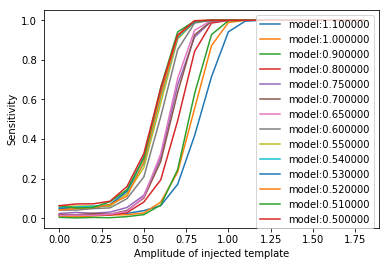

In [7]:
###
###  Testing...
###
BATCH = 4096

with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test')
    sess.run(tf.global_variables_initializer())

    #TEST_LIST = [1.4, 1.2, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
    #TRAIN_A = [1.0, 0.8, 0.6, 0.5, 0.4]
    
    plt.figure()
    for m in TRAIN_A:
        try:
            load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, m ) )
            print("Model restored from %s" % load_path )
        except: 
            continue

        gacc=[]
        gsen=[]
        
        for amp in TEST_LIST:
            sess.run(tf.local_variables_initializer())
            
            X, Y  = GWdata.get_shifted_test_set(A=amp)
            Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            i=int(np.random.random()* int(len(Xts)/BATCH) )
            xbatch = Xts[i*BATCH:(i+1)*BATCH, :]
            ybatch = Yts[i*BATCH:(i+1)*BATCH, :]
            #Xts, Yts   = GWdata.get_shifted_test_set(A=amp, shift=2000)  

            acc, sen, ttp, ttn, tfp, tfn = sess.run([accuracy, sensitivity, tp, tn, fp, fn ], 
                                                          feed_dict={ x: xbatch, y: ybatch })
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
                  % (amp, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gsen, label="model:%f"%m)
    
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    plt.show()


INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/model_1.10.ckpt
Model restored from None
Test for A= 1.80 : Acc:     0.972, Sen:     0.966, TP/TN/FP/FN:  1989  1994    43    70 
Test for A= 1.70 : Acc:     0.971, Sen:     0.962, TP/TN/FP/FN:  1929  2050    41    76 
Test for A= 1.60 : Acc:     0.967, Sen:     0.952, TP/TN/FP/FN:  1966  1995    35   100 
Test for A= 1.50 : Acc:     0.953, Sen:     0.927, TP/TN/FP/FN:  1915  1989    41   151 
Test for A= 1.40 : Acc:     0.949, Sen:     0.914, TP/TN/FP/FN:  1855  2032    34   175 
Test for A= 1.30 : Acc:     0.920, Sen:     0.857, TP/TN/FP/FN:  1757  2010    36   293 
Test for A= 1.20 : Acc:     0.876, Sen:     0.774, TP/TN/FP/FN:  1606  1982    40   468 
Test for A= 1.10 : Acc:     0.824, Sen:     0.660, TP/TN/FP/FN:  1339  2035    33   689 
Test for A= 1.00 : Acc:     0.733, Sen:     0.480, TP/TN/FP/FN:   971  2033    39  1053 
Test for A= 0.90 : Acc:     0.643, Sen:     0.301, TP/TN/FP/FN:   612  2023    41  1420 
Test for A= 0.8

Test for A= 0.70 : Acc:     0.615, Sen:     0.252, TP/TN/FP/FN:   512  2006    61  1517 
Test for A= 0.60 : Acc:     0.547, Sen:     0.124, TP/TN/FP/FN:   253  1988    65  1790 
Test for A= 0.50 : Acc:     0.522, Sen:     0.059, TP/TN/FP/FN:   120  2019    58  1899 
Test for A= 0.40 : Acc:     0.503, Sen:     0.043, TP/TN/FP/FN:    88  1973    53  1982 
Test for A= 0.30 : Acc:     0.492, Sen:     0.026, TP/TN/FP/FN:    53  1962    59  2022 
Test for A= 0.20 : Acc:     0.504, Sen:     0.024, TP/TN/FP/FN:    48  2015    44  1989 
Test for A= 0.10 : Acc:     0.506, Sen:     0.028, TP/TN/FP/FN:    57  2017    57  1965 
Test for A= 0.00 : Acc:     0.501, Sen:     0.030, TP/TN/FP/FN:    61  1993    60  1982 
INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/model_0.70.ckpt
Model restored from None
Test for A= 1.80 : Acc:     0.981, Sen:     0.979, TP/TN/FP/FN:  2028  1989    35    44 
Test for A= 1.70 : Acc:     0.979, Sen:     0.974, TP/TN/FP/FN:  2010  1999    34    53 
Test for A= 1.6

Test for A= 1.50 : Acc:     0.954, Sen:     0.967, TP/TN/FP/FN:  1965  1942   122    67 
Test for A= 1.40 : Acc:     0.950, Sen:     0.951, TP/TN/FP/FN:  1981  1911   103   101 
Test for A= 1.30 : Acc:     0.938, Sen:     0.930, TP/TN/FP/FN:  1902  1942   109   143 
Test for A= 1.20 : Acc:     0.935, Sen:     0.923, TP/TN/FP/FN:  1896  1934   108   158 
Test for A= 1.10 : Acc:     0.927, Sen:     0.902, TP/TN/FP/FN:  1857  1939    98   202 
Test for A= 1.00 : Acc:     0.912, Sen:     0.877, TP/TN/FP/FN:  1776  1959   112   249 
Test for A= 0.90 : Acc:     0.874, Sen:     0.803, TP/TN/FP/FN:  1634  1945   115   402 
Test for A= 0.80 : Acc:     0.821, Sen:     0.691, TP/TN/FP/FN:  1410  1954   101   631 
Test for A= 0.70 : Acc:     0.712, Sen:     0.474, TP/TN/FP/FN:   974  1944    96  1082 
Test for A= 0.60 : Acc:     0.608, Sen:     0.260, TP/TN/FP/FN:   529  1962   103  1502 
Test for A= 0.50 : Acc:     0.544, Sen:     0.139, TP/TN/FP/FN:   284  1943   111  1758 
Test for A= 0.40 : Ac

Test for A= 0.30 : Acc:     0.510, Sen:     0.072, TP/TN/FP/FN:   146  1944   125  1881 
Test for A= 0.20 : Acc:     0.505, Sen:     0.060, TP/TN/FP/FN:   123  1945   116  1912 
Test for A= 0.10 : Acc:     0.503, Sen:     0.070, TP/TN/FP/FN:   143  1917   139  1897 
Test for A= 0.00 : Acc:     0.506, Sen:     0.061, TP/TN/FP/FN:   122  1950   133  1891 


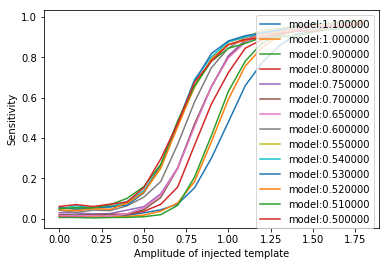

In [8]:
###
###  Testing... with shifted
###
BATCH = 4096

with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test')
    sess.run(tf.global_variables_initializer())

    #TEST_LIST = [1.4, 1.2, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
    #TRAIN_A = [1.0, 0.8, 0.6, 0.5, 0.4]
    
    plt.figure()
    for m in TRAIN_A:
        try:
            load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, m ) )
            print("Model restored from %s" % load_path )
        except:
            continue
            
        gacc=[]
        gsen=[]
        
        for amp in TEST_LIST:
            sess.run(tf.local_variables_initializer())
            X, Y  = GWdata.get_shifted_test_set(A=amp, shift=2000)
            Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            
            i=int(np.random.random()* int(len(Xts)/BATCH) )
            xbatch = Xts[i*BATCH:(i+1)*BATCH, :]
            ybatch = Yts[i*BATCH:(i+1)*BATCH, :]
            #Xts, Yts   = GWdata.get_shifted_test_set(A=amp, shift=2000)  

            acc, sen, ttp, ttn, tfp, tfn = sess.run([accuracy, sensitivity, tp, tn, fp, fn ], 
                                                          feed_dict={ x: xbatch, y: ybatch })
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
                  % (amp, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gsen, label="model:%f"%m)
    
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    plt.show()


In [10]:
##
##  Re-Training with shifted template ....
##
GWdata = GWInject("white_h_fixed.h5")
#Xt, Xv, Yt, Yv = GWdata.get_train_val_set()
#nXt = Xt.shape[0]
#nXv = Xv.shape[0]

BATCH = 256
EPOCHS = 100
MONITOR = 2

PATIENCE = 4
TOLLERENCE = 1.e-7
###
ROOT_FOLDER = '/tmp/tf_tmp'
saver = tf.train.Saver(max_to_keep=10)

TEST_LIST = [1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
TRAIN_A = [1.1, 1.0, 0.9, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5]
#TEST_LIST = [1.0, 0.9, 0.8]
#TRAIN_A = [1.2]

with tf.Session() as sess:
   
    merged = tf.summary.merge_all()
    
    sess.run(tf.global_variables_initializer())

    for amp in TRAIN_A:
        sess.run(tf.local_variables_initializer())

        ### write
        train_writer = tf.summary.FileWriter("%s/retrain_%4.2f" % (ROOT_FOLDER, amp ) )
        #train_writer.add_graph(tf.get_default_graph())
        #print('Saving graph to: %s' % ROOT_FOLDER)
    
        ### Load model
        try:
            MODEL_FILE = "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, amp )
            load_path = saver.restore(sess, MODEL_FILE )
            print("Model restored from %s" % load_path )
        except:
            continue
                    
        X, Y = GWdata.get_shifted_train_val_set(A=amp, shift=2000)
        print("Trainning for A= %f , dataset size: %d"% (amp, len(X) ))

        patience = 0
        time0 = time.time()
        for e in range(EPOCHS):
            
            ## training
            Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=None)
            STEPS   = int(len(Xt) / BATCH) 
            for i in range(STEPS):
                xbatch = Xt[i*BATCH:(i+1)*BATCH, :]
                ybatch = Yt[i*BATCH:(i+1)*BATCH, :]

                _, summary = sess.run( [optimizer, merged], feed_dict={ x:xbatch, y:ybatch } )   ## 
                train_writer.add_summary(summary)

            ### evaluate    
            loss, acc, sen = sess.run( [loss_op, accuracy, sensitivity],   feed_dict={x:Xv, y:Yv} )
            if e % MONITOR == 0:
                time1 = time.time()
                duration = time1 - time0
                time0 = time1
                speed = STEPS * BATCH *MONITOR / duration
                print('  Epoch: %3d, loss: %10.3e acc: %4.2g sen: %4.2f sec: %5.1f speed: %7.1f wf/sec' 
                      % (e, loss, acc, sen, duration, speed) )
            if loss < TOLLERENCE:
                if patience > PATIENCE: break
                patience += 1
            else:
                patience = 0
            
        save_path = saver.save(sess, "%s/smodel_%4.2f.ckpt" % (ROOT_FOLDER, amp ) )
        print("Model saved at %s" % save_path)


INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/model_1.10.ckpt
Model restored from None
Trainning for A= 1.100000 , dataset size: 10320
  Epoch:   0, loss:  7.093e+00 acc: 0.85 sen: 0.91 sec:   3.0 speed:  5157.9 wf/sec
  Epoch:   2, loss:  8.765e+00 acc:  0.9 sen: 0.90 sec:   5.0 speed:  3046.2 wf/sec
  Epoch:   4, loss:  1.461e+00 acc: 0.92 sen: 0.92 sec:   5.1 speed:  3036.0 wf/sec
  Epoch:   6, loss:  1.213e+00 acc: 0.94 sen: 0.94 sec:   5.0 speed:  3077.4 wf/sec
  Epoch:   8, loss:  6.817e-01 acc: 0.95 sen: 0.95 sec:   5.1 speed:  3040.5 wf/sec
  Epoch:  10, loss:  4.450e-01 acc: 0.96 sen: 0.95 sec:   5.0 speed:  3076.9 wf/sec
  Epoch:  12, loss:  3.603e-01 acc: 0.96 sen: 0.96 sec:   4.9 speed:  3106.6 wf/sec
  Epoch:  14, loss:  3.659e-01 acc: 0.96 sen: 0.96 sec:   5.0 speed:  3057.6 wf/sec
  Epoch:  16, loss:  2.539e-01 acc: 0.97 sen: 0.97 sec:   5.0 speed:  3054.4 wf/sec
  Epoch:  18, loss:  1.079e-02 acc: 0.97 sen: 0.97 sec:   5.1 speed:  3025.3 wf/sec
  Epoch:  20, los

Model restored from None
Trainning for A= 0.800000 , dataset size: 10320
  Epoch:   0, loss:  1.825e+01 acc: 0.63 sen: 0.65 sec:   2.6 speed:  6020.3 wf/sec
  Epoch:   2, loss:  1.340e+01 acc:  0.7 sen: 0.63 sec:   5.1 speed:  3036.4 wf/sec
  Epoch:   4, loss:  1.020e+01 acc: 0.73 sen: 0.69 sec:   5.2 speed:  2935.4 wf/sec
  Epoch:   6, loss:  9.181e+00 acc: 0.75 sen: 0.70 sec:   5.3 speed:  2871.1 wf/sec
  Epoch:   8, loss:  8.368e+00 acc: 0.76 sen: 0.72 sec:   5.2 speed:  2930.1 wf/sec
  Epoch:  10, loss:  7.050e+00 acc: 0.77 sen: 0.75 sec:   5.2 speed:  2977.3 wf/sec
  Epoch:  12, loss:  8.861e+00 acc: 0.78 sen: 0.75 sec:   5.1 speed:  3006.2 wf/sec
  Epoch:  14, loss:  6.291e+00 acc: 0.79 sen: 0.77 sec:   5.0 speed:  3079.3 wf/sec
  Epoch:  16, loss:  5.186e+00 acc: 0.79 sen: 0.77 sec:   5.0 speed:  3054.5 wf/sec
  Epoch:  18, loss:  5.537e+00 acc:  0.8 sen: 0.78 sec:   5.0 speed:  3059.5 wf/sec
  Epoch:  20, loss:  3.596e+00 acc: 0.81 sen: 0.78 sec:   5.0 speed:  3054.2 wf/sec
  E

  Epoch:  90, loss:  1.658e-01 acc: 0.88 sen: 0.88 sec:   5.0 speed:  3058.7 wf/sec
  Epoch:  92, loss:  3.643e-01 acc: 0.89 sen: 0.89 sec:   5.0 speed:  3058.9 wf/sec
  Epoch:  94, loss:  6.128e-01 acc: 0.89 sen: 0.88 sec:   5.0 speed:  3042.0 wf/sec
  Epoch:  96, loss:  2.709e-01 acc: 0.89 sen: 0.89 sec:   5.0 speed:  3057.1 wf/sec
  Epoch:  98, loss:  9.996e-02 acc: 0.89 sen: 0.89 sec:   5.0 speed:  3076.0 wf/sec
Model saved at /tmp/tf_tmp/smodel_0.75.ckpt
INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/model_0.70.ckpt
Model restored from None
Trainning for A= 0.700000 , dataset size: 10320
  Epoch:   0, loss:  2.081e+01 acc: 0.64 sen: 0.77 sec:   2.6 speed:  6008.2 wf/sec
  Epoch:   2, loss:  1.746e+01 acc: 0.68 sen: 0.75 sec:   5.2 speed:  2955.4 wf/sec
  Epoch:   4, loss:  1.366e+01 acc: 0.69 sen: 0.77 sec:   5.3 speed:  2891.5 wf/sec
  Epoch:   6, loss:  1.238e+01 acc:  0.7 sen: 0.77 sec:   5.2 speed:  2974.6 wf/sec
  Epoch:   8, loss:  1.113e+01 acc: 0.71 sen: 0.77 sec:  

  Epoch:  78, loss:  1.397e+00 acc:  0.8 sen: 0.80 sec:   5.0 speed:  3053.5 wf/sec
  Epoch:  80, loss:  1.121e+00 acc:  0.8 sen: 0.81 sec:   5.0 speed:  3053.4 wf/sec
  Epoch:  82, loss:  7.607e-01 acc:  0.8 sen: 0.81 sec:   5.0 speed:  3066.3 wf/sec
  Epoch:  84, loss:  8.681e-01 acc: 0.81 sen: 0.81 sec:   5.0 speed:  3064.9 wf/sec
  Epoch:  86, loss:  1.050e+00 acc: 0.81 sen: 0.81 sec:   5.0 speed:  3096.9 wf/sec
  Epoch:  88, loss:  1.229e+00 acc: 0.81 sen: 0.81 sec:   5.0 speed:  3047.6 wf/sec
  Epoch:  90, loss:  7.120e-01 acc: 0.81 sen: 0.81 sec:   5.1 speed:  3036.2 wf/sec
  Epoch:  92, loss:  6.545e-01 acc: 0.81 sen: 0.82 sec:   5.1 speed:  3029.3 wf/sec
  Epoch:  94, loss:  5.314e-01 acc: 0.82 sen: 0.82 sec:   5.1 speed:  3025.3 wf/sec
  Epoch:  96, loss:  4.737e-01 acc: 0.82 sen: 0.82 sec:   5.0 speed:  3059.4 wf/sec
  Epoch:  98, loss:  9.176e-01 acc: 0.82 sen: 0.82 sec:   5.0 speed:  3056.3 wf/sec
Model saved at /tmp/tf_tmp/smodel_0.65.ckpt
INFO:tensorflow:Restoring parame

  Epoch:  66, loss:  2.092e+00 acc:  0.7 sen: 0.70 sec:   5.1 speed:  3012.3 wf/sec
  Epoch:  68, loss:  2.467e+00 acc: 0.71 sen: 0.70 sec:   5.1 speed:  3024.7 wf/sec
  Epoch:  70, loss:  2.409e+00 acc: 0.71 sen: 0.70 sec:   5.1 speed:  3034.3 wf/sec
  Epoch:  72, loss:  1.960e+00 acc: 0.71 sen: 0.70 sec:   5.1 speed:  3039.3 wf/sec
  Epoch:  74, loss:  2.157e+00 acc: 0.71 sen: 0.71 sec:   5.1 speed:  3013.8 wf/sec
  Epoch:  76, loss:  1.696e+00 acc: 0.71 sen: 0.71 sec:   5.1 speed:  3028.9 wf/sec
  Epoch:  78, loss:  1.521e+00 acc: 0.71 sen: 0.71 sec:   5.1 speed:  3028.6 wf/sec
  Epoch:  80, loss:  1.804e+00 acc: 0.72 sen: 0.71 sec:   5.1 speed:  3030.7 wf/sec
  Epoch:  82, loss:  1.501e+00 acc: 0.72 sen: 0.71 sec:   5.1 speed:  3041.2 wf/sec
  Epoch:  84, loss:  1.667e+00 acc: 0.72 sen: 0.71 sec:   5.1 speed:  3031.7 wf/sec
  Epoch:  86, loss:  2.896e+00 acc: 0.72 sen: 0.71 sec:   5.0 speed:  3047.6 wf/sec
  Epoch:  88, loss:  1.664e+00 acc: 0.72 sen: 0.71 sec:   5.1 speed:  3012.8

  Epoch:  54, loss:  1.906e+00 acc: 0.69 sen: 0.70 sec:   5.2 speed:  2965.8 wf/sec
  Epoch:  56, loss:  2.218e+00 acc: 0.69 sen: 0.70 sec:   5.1 speed:  3014.0 wf/sec
  Epoch:  58, loss:  1.667e+00 acc: 0.69 sen: 0.70 sec:   5.1 speed:  3014.7 wf/sec
  Epoch:  60, loss:  1.834e+00 acc: 0.69 sen: 0.70 sec:   5.1 speed:  3002.3 wf/sec
  Epoch:  62, loss:  1.845e+00 acc:  0.7 sen: 0.70 sec:   5.1 speed:  3010.5 wf/sec
  Epoch:  64, loss:  2.715e+00 acc:  0.7 sen: 0.70 sec:   5.1 speed:  3012.8 wf/sec
  Epoch:  66, loss:  1.540e+00 acc:  0.7 sen: 0.70 sec:   5.0 speed:  3053.9 wf/sec
  Epoch:  68, loss:  1.489e+00 acc:  0.7 sen: 0.70 sec:   5.1 speed:  3017.1 wf/sec
  Epoch:  70, loss:  2.159e+00 acc:  0.7 sen: 0.70 sec:   5.0 speed:  3054.3 wf/sec
  Epoch:  72, loss:  2.531e+00 acc:  0.7 sen: 0.70 sec:   5.1 speed:  3007.7 wf/sec
  Epoch:  74, loss:  1.131e+00 acc:  0.7 sen: 0.70 sec:   5.1 speed:  3009.2 wf/sec
  Epoch:  76, loss:  1.253e+00 acc: 0.71 sen: 0.70 sec:   5.1 speed:  3008.0

  Epoch:  42, loss:  6.931e-01 acc:  0.5 sen: 0.03 sec:   5.0 speed:  3065.0 wf/sec
  Epoch:  44, loss:  6.932e-01 acc:  0.5 sen: 0.02 sec:   5.0 speed:  3078.0 wf/sec
  Epoch:  46, loss:  6.932e-01 acc:  0.5 sen: 0.02 sec:   5.0 speed:  3094.6 wf/sec
  Epoch:  48, loss:  6.929e-01 acc:  0.5 sen: 0.02 sec:   5.0 speed:  3064.4 wf/sec
  Epoch:  50, loss:  6.932e-01 acc:  0.5 sen: 0.02 sec:   5.0 speed:  3066.8 wf/sec
  Epoch:  52, loss:  6.931e-01 acc:  0.5 sen: 0.02 sec:   5.0 speed:  3055.0 wf/sec
  Epoch:  54, loss:  6.931e-01 acc:  0.5 sen: 0.02 sec:   4.9 speed:  3118.2 wf/sec
  Epoch:  56, loss:  6.929e-01 acc:  0.5 sen: 0.02 sec:   5.0 speed:  3058.5 wf/sec
  Epoch:  58, loss:  6.931e-01 acc:  0.5 sen: 0.02 sec:   5.0 speed:  3093.7 wf/sec
  Epoch:  60, loss:  6.932e-01 acc:  0.5 sen: 0.02 sec:   5.0 speed:  3067.7 wf/sec
  Epoch:  62, loss:  6.929e-01 acc:  0.5 sen: 0.02 sec:   5.0 speed:  3076.8 wf/sec
  Epoch:  64, loss:  6.932e-01 acc:  0.5 sen: 0.02 sec:   5.0 speed:  3075.0